# **[딥러닝을 이용한 자연어 처리 입문]**

+ 11 RNN을 이용한 텍스트 분류 

+ 7) 네이버 쇼핑 리뷰 감성 분류하기(Naver Shopping Review Sentiment Analysis)를 참고하였습니다. 

+ https://wikidocs.net/94600

In [11]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

C:\3pm\Final\final_project\Mecab-ko-for-Google-Colab


fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.
'bash'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import io

## 데이터 불러오기

In [17]:
data = pd.read_csv('네이버 쇼핑/Apple(shopping).csv', index_col=0)
data.head()

FileNotFoundError: [Errno 2] No such file or directory: '네이버 쇼핑/Apple(shopping).csv'

## 데이터 전처리

In [3]:
data = data.dropna()
data = data.drop_duplicates()

In [4]:
data["label"] = np.select([data.star > 3], [1], default=0)
data[:5]

,type,category,review,star,label
0,아이패드,별점,고장나서 옴 수리하기도 돈아까윰,1,0
1,아이패드,별점,그냥 모든게 허접해요,1,0
3,아이패드,별점,대응이 정말 안좋아요,1,0
4,아이패드,별점,액정 불량화소 있어서 말하니 센터가서 처리하라고하네 편하게 받고 싶은데 다시 가서 ...,1,0
5,아이패드,별점,일주일이 넘도록 환불처리가 되지 않아 빠른 답변 부탁드립니다,1,0


In [5]:
data['star'].nunique(), data["review"].nunique(), data["star"].nunique() # (5, 2342, 5)

(5, 2342, 5)

In [6]:
print(data.isnull().sum())

type        0
category    0
review      0
star        0
label       0
dtype: int64


In [7]:
train_data, test_data = train_test_split(data, test_size = 0.3, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 1647
테스트용 리뷰의 개수 : 706


## 레이블 분포 확인

<AxesSubplot:>

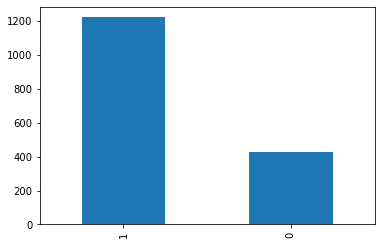

In [8]:
train_data["label"].value_counts().plot(kind = 'bar')

In [9]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0    426
1      1   1221


## 토큰화

In [10]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

Exception: Install MeCab in order to use it: http://konlpy.org/en/latest/install/

In [42]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과',
             '도','를','으로','자','에','와','한','하다', '게',
             '고', '네', '는', '다', '들', '듯', '으로', '은',
             '을', '인', '임', '자', '좀', '지', '요']

In [43]:
train_data["tokenized"] = train_data["review"].apply(mecab.morphs)
train_data["tokenized"] = train_data["tokenized"].apply(lambda x : [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
test_data["tokenized"] = test_data["review"].apply(mecab.morphs)
test_data["tokenized"] = test_data["tokenized"].apply(lambda x : [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [46]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('하', 312), ('네요', 202), ('있', 158), ('는데', 156), ('안', 148), ('받', 125), ('했', 123), ('월', 119), ('습니다', 110), ('되', 105), ('좋', 102), ('제품', 100), ('어요', 82), ('거', 81), ('어', 78), ('없', 76), ('만', 74), ('주', 69), ('았', 69), ('에서', 69)]


In [47]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('하', 1312), ('좋', 765), ('있', 531), ('습니다', 528), ('네요', 520), ('는데', 511), ('했', 450), ('어요', 436), ('너무', 323), ('아요', 313), ('받', 312), ('로', 300), ('되', 297), ('사용', 296), ('았', 293), ('구매', 290), ('합니다', 262), ('같', 251), ('쓰', 249), ('어', 245)]


In [49]:
positive_len = train_data[train_data['label']==1]["tokenized"].map(lambda x : len(x))
np.mean(positive_len)

31.245700245700245

In [50]:
negative_len = train_data[train_data['label']==0]["tokenized"].map(lambda x : len(x))
np.mean(negative_len)

25.330985915492956

In [62]:
X_train = train_data["tokenized"].values
y_train = train_data["label"].values
X_test = test_data["tokenized"].values
y_test = test_data["label"].values

## 정수 인코딩

In [63]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [64]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 단어와 빈도수의 쌍을 key와 value로
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 4828
등장 빈도가 1번 이하인 희귀 단어의 수: 2320
단어 집합에서 희귀 단어의 비율: 48.05302402651201
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.740304850639532


In [65]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 2510


In [66]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [67]:
print(X_train[:3])

[[224, 518, 625, 670, 73, 55, 1495, 4], [74, 1, 231, 49, 85, 2, 1845, 5, 7, 1254, 1255, 44, 21, 421, 15, 2, 87], [82, 671, 82, 4, 199, 53, 42, 50, 422, 85, 102, 8, 6, 291, 43, 1, 59, 184, 27, 1084, 103, 49, 1, 7, 148, 30, 46, 75, 54, 80, 672, 4, 185, 271, 75, 54, 80, 2, 165, 123, 47, 9, 72, 673, 1496, 180, 76, 325, 17, 1, 1497, 213, 1846, 1, 26, 1498, 1499, 1847, 1500, 672, 4, 124, 1, 88, 547, 311, 674, 243, 1, 865, 52, 5, 149, 244, 201, 82, 672, 61, 235, 53, 42, 64, 201, 3, 26, 22, 4, 124, 360, 1501, 245, 73, 3, 7, 793, 1502, 72, 1, 19, 1, 236, 4, 277, 61, 1503, 33, 4]]


In [68]:
print(X_test[:3])

[[190, 363, 461, 162, 408, 44, 21, 1, 694, 98, 1, 79, 1986, 710, 8, 186, 2, 1, 61], [209, 32, 44, 21], [194, 331, 86, 66, 8, 6, 330, 331, 74, 280]]


## 패딩

리뷰의 최대 길이 : 518
리뷰의 평균 길이 : 29.715846994535518


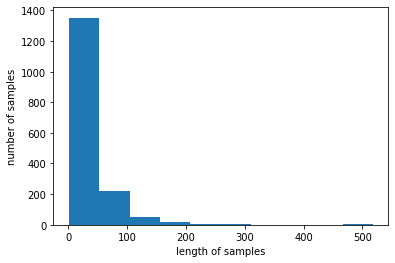

In [70]:
print('리뷰의 최대 길이 :', max(len(l) for l in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train)) / len(X_train))
plt.hist([len(s) for s in X_train], bins = 10)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [77]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s) <= max_len):
            cnt = cnt+1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s' %(max_len, (cnt / len(nested_list))* 100))

In [82]:
max_len = 200
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 200 이하인 샘플의 비율 : 99.27140255009107


In [83]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## GRU로 네이버 쇼핑 리뷰 감성 분류하기

In [84]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [85]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation = 'sigmoid'))

In [86]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [87]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs = 15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
22/22 [==============================] - 10s 325ms/step - loss: 0.5710 - acc: 0.7320 - val_loss: 0.5092 - val_acc: 0.7576

Epoch 00001: val_acc improved from -inf to 0.75758, saving model to best_model.h5
Epoch 2/15
22/22 [==============================] - 7s 304ms/step - loss: 0.4560 - acc: 0.7935 - val_loss: 0.4403 - val_acc: 0.7909

Epoch 00002: val_acc improved from 0.75758 to 0.79091, saving model to best_model.h5
Epoch 3/15
22/22 [==============================] - 7s 301ms/step - loss: 0.3264 - acc: 0.8709 - val_loss: 0.4187 - val_acc: 0.8091

Epoch 00003: val_acc improved from 0.79091 to 0.80909, saving model to best_model.h5
Epoch 4/15
22/22 [==============================] - 7s 303ms/step - loss: 0.2902 - acc: 0.9058 - val_loss: 0.4217 - val_acc: 0.8121

Epoch 00004: val_acc improved from 0.80909 to 0.81212, saving model to best_model.h5
Epoch 5/15
22/22 [==============================] - 7s 306ms/step - loss: 0.2175 - acc: 0.9241 - val_loss: 0.4917 - val_acc: 0.860

In [88]:
load_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (load_model.evaluate(X_test, y_test)[1]))

23/23 [==============================] - 1s 44ms/step - loss: 0.5444 - acc: 0.8258

 테스트 정확도: 0.8258


## 리뷰 예측해보기

In [103]:
def sentiment_predict(new_sentence):
    new_sentence = mecab.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(load_model.predict(pad_new)) # 예측
    
    if (score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [104]:
sentiment_predict("이 상품 진짜 좋아요... 저는 강추합니다. 대박")

94.48% 확률로 긍정 리뷰입니다.


In [105]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

76.77% 확률로 부정 리뷰입니다.


In [106]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

96.49% 확률로 긍정 리뷰입니다.


In [107]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

91.36% 확률로 긍정 리뷰입니다.


In [109]:
sentiment_predict('아이패드 화면 불량인가요,안녕하세요이번에 아이패드랑 펜슬까지 구매완료해서아이폰 애플워치 에어팟ㅎㅎㅎ 사과농장 다꾸럈어요처음으로 태블릿을 샀는데 ㅋㅍ에서 사서 신나게 펜슬로 끄적이고있었는데 동영상처럼 오류가 뜨더라구요ㅠ                도움말라이센스            동영상 인코딩 중입니다분 이상 소요될 수 있으며 영상의 길이에 따라 소요 시간은 달라집니다  마우스를 드래그 하세요 도움말  멀티트랙의 트랙별 영상은 우측 관련영상에서 볼 수 있습니다선거광고 안내       음소거   화질 선택 옵션 화질  전체화면   광고정보 더보기초 후 초 후 재생광고 후 계속됩니다 공유소스 코드     주소복사 소스        복사 미지원으로  코드 퍼가기 기능은 더 이상 지원되지않습니다도움말 플레이어  복사 레이어 닫기접기펴기아이패드불량아이패드에어불량아이패드멍현상에어화면눌림현상 보시면 이렇게 오류가 생기더라구요ㅠ 크게 힘을 누른것도 아닌데 펜슬로 쓰다보니 나비모양처럼 되던데 불량인가요찝찝해서 교환해서 새상품을 받았는데 새로받은걸 확인 차 눌러보니깐 새상품에서도 나타나더라구요 기존에 갖고있던 갤탭은 나비모양처럼 멍현상은 없던데 제가 뽑기실패를 한건지 예민한건지 모르겠어요ㅠ')

90.29% 확률로 부정 리뷰입니다.


In [ ]:
sen